In [10]:
import Ipynb_importer
import DaraPre

In [14]:
import sys
sys.path.append(r'/Users/douzi/Desktop/application_of_data/step1-data/DaraPre.ipynb')
from DaraPre import *


In [15]:
poly_features = app_train[[ 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[[ 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [16]:
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)


Polynomial Features shape:  (307511, 20)


In [17]:
poly_transformer.get_feature_names_out(input_features = [ 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_2^3',
       'EXT_SOURCE_2^2 EXT_SOURCE_3', 'EXT_SOURCE_2^2 DAYS_BIRTH',
       'EXT_SOURCE_2 EXT_SOURCE_3^2',
       'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH'], dtype=object)

In [18]:
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out([ 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3              -0.194235
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH   -0.181417
EXT_SOURCE_2^2 EXT_SOURCE_3            -0.176589
EXT_SOURCE_2 EXT_SOURCE_3^2            -0.171729
EXT_SOURCE_2                           -0.160303
EXT_SOURCE_3                           -0.157397
EXT_SOURCE_2 DAYS_BIRTH                -0.156879
EXT_SOURCE_3 DAYS_BIRTH                -0.150936
EXT_SOURCE_2^2                         -0.149502
EXT_SOURCE_2^2 DAYS_BIRTH              -0.149298
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [19]:
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out([ 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 199)
Testing data with polynomial features shape:   (48744, 199)


In [20]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [21]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

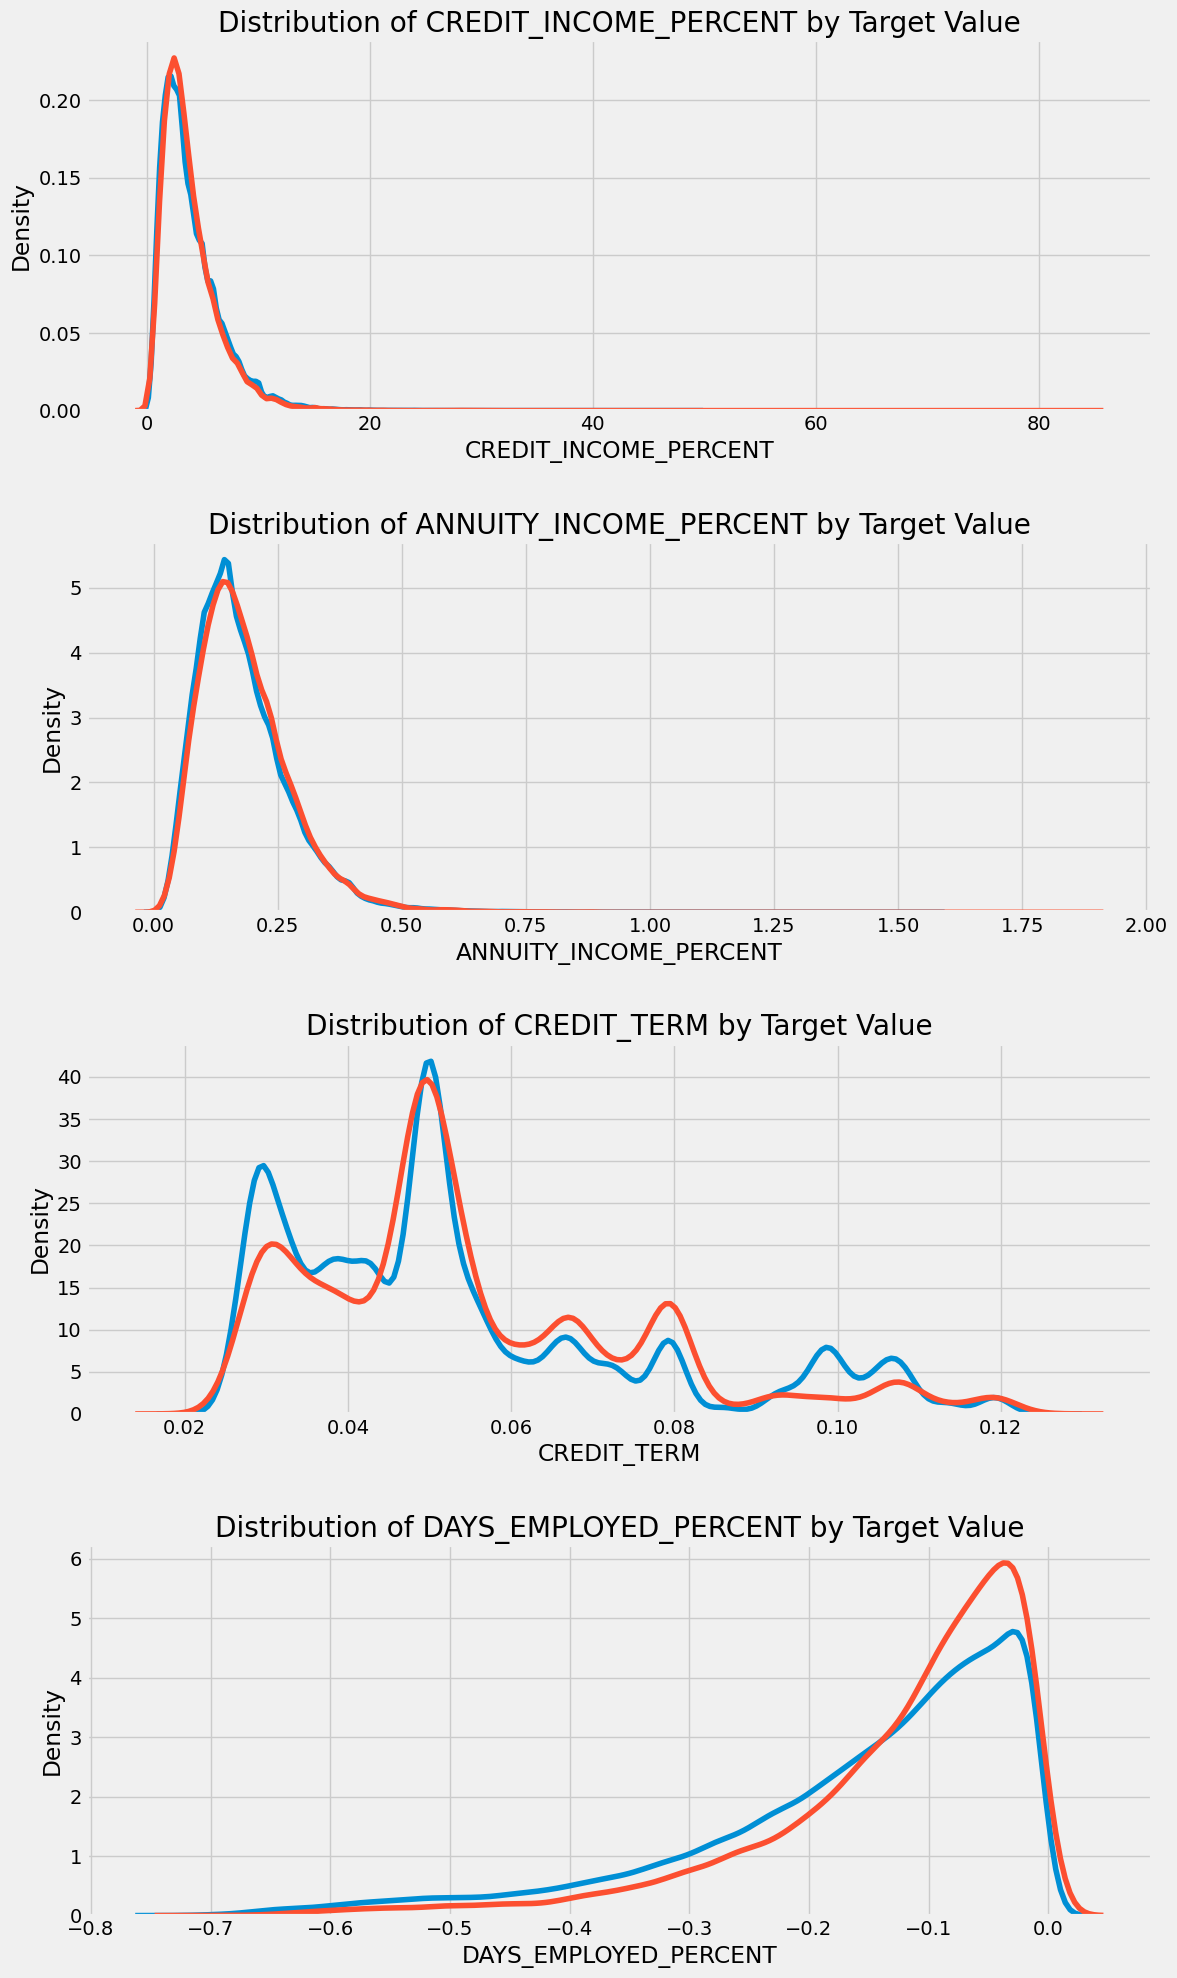

In [22]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)